In [25]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import dlib
from google.colab.patches import cv2_imshow

import shutil
import glob


## Experiments 

In [ ]:
# haar cascade classifier detection 

# base_path = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment datasets/cartoon dataset/cartoonset10k'
# list_ = os.listdir(base_path)
# ims = cv.imread(os.path.join(base_path, list_[12]))
# gray = cv.cvtColor(ims, cv.COLOR_RGB2GRAY)
# face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
# eyes_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')

# detected_faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5)
# detected_eyes = eyes_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5)
# print(len(detected_faces))
# column, row, width, height = detected_faces[0]
# cols, r, wid, hei = detected_eyes[0]

# resized_face = img[row: row + height, column: column+ width]
# resized_eyes = img[r: r + hei, cols: cols+ wid]

# cv2_imshow(resized_face)

In [ ]:
base_path = '/content/cartoon'
list_ = os.listdir(base_path)
img = cv.imread(os.path.join(base_path, list_[14]))
print(img.shape)
gray_image = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
face_detect = dlib.get_frontal_face_detector()
os.chdir('/content/drive/MyDrive/UCL_machine_learning_course ')
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
detected_faces = face_detect(gray_image)

for rect in detected_faces:
    column = rect.left()
    row = rect.top()
    width  = rect.right() - column
    height = rect.bottom() - row
    shape = predictor(gray_image, rect)

    for n in range(0,28):
       x = shape.part(n).x
       y = shape.part(n).y
       cv.circle(img, (x, y), 2, (255, 0, 0), -1)

cv2_imshow(img)

In [4]:
!cp -r '/content/drive/MyDrive/UCL_machine_learning_course /Assignment_datasets/cartoon_dataset/cartoonset10k' '/content'
!cp -r '/content/drive/MyDrive/UCL_machine_learning_course /Assignment_datasets/cartoon_dataset/cartoon' '/content'
!cp -r '/content/drive/MyDrive/UCL_machine_learning_course /Assignment_datasets/cartoon_dataset/Labels' '/content'


In [8]:
shutil.rmtree('/content/Labels')
shutil.rmtree('/content/cartoon')
shutil.rmtree('/content/cartoonset10k')

## Data processing 

In [ ]:
# data separation 

base_path = '/content/cartoonset10k'
cartoon_images = '/content/cartoon'
cartoon_labels = '/content/Labels'


images_file = sorted(os.listdir(base_path))

for counter, i in enumerate(images_file):

  if str(i).endswith('.png'):
    input_path = os.path.join(base_path, i)
    output_path = os.path.join(cartoon_images, i)
    shutil.move(input_path, output_path)
    print(' Processed an image file with name {}'.format(i))

  elif str(i).endswith('.csv'):
    input_path = os.path.join(base_path, i)
    output_path = os.path.join(cartoon_labels, i)
    shutil.move(input_path, output_path)
    print('processed csv file with name {}'.format(i))
  
  else:
    print('Unrecognized file with name {}'.format(i))
    continue

In [21]:
def train_test(image_path, label_path):

  list_images = os.listdir(image_path)
  list_labels = os.listdir(label_path)

  print(list_images)
  print(list_labels)

  train_data = []
  labels_data = []

  for i in list_images[:5000]:
    print(' image number being processed is {}'.format(i))
    for j in list_labels:
      if str(i)[:-4] == str(j)[:-4]:

        df = pd.read_csv(os.path.join(label_path, j))
        df.columns = ['attribute','actual', 'total']
        shape_atri = df.iloc[6,1]
        labels_data.append(shape_atri)

        ims = cv.imread(os.path.join(image_path, i))
        gray_image = cv.cvtColor(ims, cv.COLOR_RGB2GRAY)
        face_detect = dlib.get_frontal_face_detector()
        os.chdir('/content/drive/MyDrive/UCL_machine_learning_course ')
        predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        detected_faces = face_detect(gray_image)

        for rect in detected_faces:
          column = rect.left()
          row = rect.top()
          width  = rect.right() - column
          height = rect.bottom() - row
          shape = predictor(gray_image, rect)

          cord_array = np.zeros((28, 2), dtype = 'int')
          for i in range(0,28):
            cord_array[i] = (shape.part(i).x, shape.part(i).y)
          
          face_shapes = np.reshape(cord_array, [56])
          tr_shapes = [np.transpose(face_shapes)/max(face_shapes)]
          train_data.append(tr_shapes)

        else:
          continue
      # labels stuff

  return train_data, labels_data

def encoding_labels(y_labels):
  reshaped = np.reshape(y_labels, (-1,1))
  enc = OneHotEncoder(handle_unknown='ignore')
  enc_array = pd.DataFrame(enc.fit_transform(reshaped).toarray())

  return enc_array

def preprocess_data(X_path, y_path):

  # load data 
  df = pd.read_csv(X_path)
  df = df.drop('Unnamed: 0', axis = 1)
  x_data = df.to_numpy()

  #labels 
  labels_df = pd.read_csv(y_path)
  labels_df = labels_df.drop('Unnamed: 0', axis = 1)
  label = np.asarray(labels_df['0']).reshape(-1,1)

  # apply one hot encoding 
  enc = OneHotEncoder(handle_unknown='ignore')
  y_labels = enc.fit_transform(label).toarray()
 
  print(len(y_labels))
  print(len(x_data))

  x_train, x_val, y_train, y_val = train_test_split(x_data, y_labels[:4031], test_size = 0.3, shuffle = True)

  return x_train, x_val, y_train, y_val

In [ ]:
train_data, labels_data = train_test('/content/cartoon', '/content/Labels')

In [12]:
pd.DataFrame(np.asarray(train_data).reshape((-1, 56))).to_csv('/content/drive/MyDrive/UCL_machine_learning_course /Assignment_datasets/cartoon_dataset/Cart_file.csv')
pd.DataFrame(np.asarray(labels_data)).to_csv('/content/drive/MyDrive/UCL_machine_learning_course /Assignment_datasets/cartoon_dataset/Cart_labels.csv')

In [22]:
path_x = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment_datasets/cartoon_dataset/Cart_file.csv'
path_y = '/content/drive/MyDrive/UCL_machine_learning_course /Assignment_datasets/cartoon_dataset/Cart_labels.csv'
x_train, x_val, y_train, y_val = preprocess_data(path_x,path_y)

5000
4031


## Neural Network 

In [ ]:
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0.]


In [40]:
def get_basic_model(activation):

  model = keras.Sequential()
  model.add(keras.layers.Dense(100, input_dim = (56), activation = activation))
  model.add(keras.layers.Dense(80, activation = activation))
  model.add(keras.layers.Dense(60, activation = activation))
  model.add(keras.layers.Dense(40, activation = activation))
  model.add(keras.layers.Dense(20, activation = activation))
  model.add(keras.layers.Dense(10, activation = activation))
  model.add(keras.layers.Dense(7, activation= 'softmax'))
  
  return model

In [41]:
model = get_basic_model('relu')
print(model.summary())
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True), optimizer='SGD', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=64)
y_pred = model.predict(x_val)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               5700      
                                                                 
 dense_25 (Dense)            (None, 80)                8080      
                                                                 
 dense_26 (Dense)            (None, 60)                4860      
                                                                 
 dense_27 (Dense)            (None, 40)                2440      
                                                                 
 dense_28 (Dense)            (None, 20)                820       
                                                                 
 dense_29 (Dense)            (None, 10)                210       
                                                                 
 dense_30 (Dense)            (None, 7)                

In [30]:
layer_1 = history.history['accuracy']

In [33]:
layer_2 = history.history['accuracy']

In [36]:
layer_3 = history.history['accuracy']

In [39]:
layer_4 = history.history['accuracy']

In [42]:
layer_5 = history.history['accuracy']

In [44]:
layer_1_1 = [x *100 for x in layer_1]
layer_2_1 = [x *100 for x in layer_2]
layer_3_1 = [x *100 for x in layer_3]
layer_4_1 = [x *100 for x in layer_4]
layer_5_1 = [x *100 for x in layer_5]

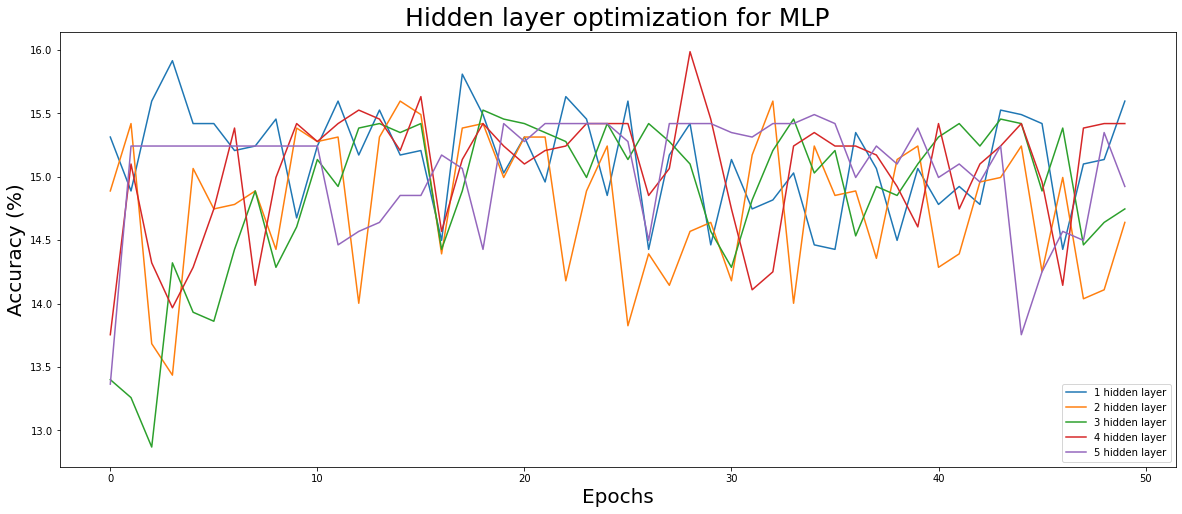

In [49]:
plt.figure(figsize = (20,8))
plt.title('Hidden layer optimization for MLP', fontsize = 25)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Accuracy (%)', fontsize = 20)
plt.plot(layer_1_1, label = '1 hidden layer')
plt.plot(layer_2_1, label = '2 hidden layer')
plt.plot(layer_3_1, label = '3 hidden layer')
plt.plot(layer_4_1, label = '4 hidden layer')
plt.plot(layer_5_1, label = '5 hidden layer')
plt.legend()

In [47]:
print(len(layer_1_1))

50


In [ ]:

# define number of hidden layers ..
n_hidden_1 = 2048  # 1st layer number of neurons
n_hidden_2 = 2048  # 2nd layer number of neurons

# inputs placeholders
X = tf.placeholder("float", [None, 56])
Y = tf.placeholder("float", [None, 7])  # 2 output classes

# flatten image features into one vector (i.e. reshape image feature matrix into a vector)
# images_flat = tf.contrib.layers.flatten(X)  
images_flat = tf.compat.v1.layers.flatten(X)  


# weights and biases are initialized from a normal distribution with a specified standard devation stddev
stddev = 0.01

# define placeholders for weights and biases in the graph
weights = {
    'hidden_layer1': tf.Variable(tf.random_normal([68 * 2, n_hidden_1], stddev=stddev)),
    'hidden_layer2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, 2], stddev=stddev))
}

biases = {
    'bias_layer1': tf.Variable(tf.random_normal([n_hidden_1], stddev=stddev)),
    'bias_layer2': tf.Variable(tf.random_normal([n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([2], stddev=stddev))
}



<ipython-input-126-bc33529e4dce>:11: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  images_flat = tf.compat.v1.layers.flatten(X)


In [ ]:
def multilayer_perceptron():

  # Hidden fully connected layer 1
  layer_1 = tf.add(tf.matmul(images_flat, weights['hidden_layer1']), biases['bias_layer1'])
  layer_1 = tf.sigmoid(layer_1)

  # Hidden fully connected layer 2
  layer_2 = tf.add(tf.matmul(layer_1, weights['hidden_layer2']), biases['bias_layer2'])
  layer_2 = tf.sigmoid(layer_2)

  # Output fully connected layer
  out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

  return out_layer


In [ ]:
# learning parameters
learning_rate = 1e-5
training_epochs = 500

# display training accuracy every ..
display_accuracy_step = 10

logits, X, Y = multilayer_perceptron()

# define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# define training graph operation
train_op = optimizer.minimize(loss_op)

# graph operation to initialize all variables
init_op = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:

        # run graph weights/biases initialization op
        sess.run(init_op)
        # begin training loop ..
        for epoch in range(training_epochs):
            # complete code below
            # run optimization operation (backprop) and cost operation (to get loss value)
            _, cost = sess.run([train_op, loss_op], feed_dict={X: x_train,
                                                               Y: y_train})

            # Display logs per epoch step
            print("Epoch:", '%04d' % (epoch + 1), "cost={:.9f}".format(cost))
                
            if epoch % display_accuracy_step == 0:
                pred = tf.nn.softmax(logits)  # Apply softmax to logits
                correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))

                # calculate training accuracy
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                print("Accuracy: {:.3f}".format(accuracy.eval({X: x_train, Y: y_train})))

        print("Optimization Finished!")

        # -- Define and run test operation -- #
        
        # apply softmax to output logits
        pred = tf.nn.softmax(logits)
        
        #  derive inffered calasses as the class with the top value in the output density function
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        
        # calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            
        # complete code below
        # run test accuracy operation ..
        print("Test Accuracy:", accuracy.eval({X: test_images, Y: test_labels}))
